In [1]:
import numpy as np
import random
import torch
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit as GSS
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

from seaborn import displot, boxplot
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [2]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
MODEL_NAME = 'bert-base-uncased'
BATCH_SIZE = 16
NUM_WORKERS = 4
MAX_LEN = 128

In [3]:
df_train = read_csv('./data/support_train_new.csv', encoding='UTF-8')
df_dev_test = read_csv('./data/support_dev_new.csv', encoding='UTF-8')

In [4]:
def label_to_numeric(x):
    if x == 'REFUTES':
        return 0
    elif x == 'SUPPORTS':
        return 1
    elif x == 'NOT ENOUGH INFO':
        return 2

df_train['label_numeric'] = df_train.label.apply(label_to_numeric)
df_dev_test['label_numeric'] = df_dev_test.label.apply(label_to_numeric)

In [5]:
columns_to_keep = ['id','claim','evidence_text','label_numeric']
df_train = df_train[columns_to_keep]
df_dev_test = df_dev_test[columns_to_keep]

SPLIT_METHOD = 'GSS'
if SPLIT_METHOD == 'GSS':
    gss = GSS(n_splits=1, train_size=.5, random_state=42)
    dev_ix, test_ix = next(gss.split(df_dev_test, groups=df_dev_test.id))
    df_test = df_dev_test.iloc[test_ix]
    df_dev = df_dev_test.iloc[dev_ix]
else:
    df_test, df_dev = train_test_split(df_dev_test, test_size=.5)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_dev = df_dev.reset_index(drop=True)
df_train.shape, df_test.shape, df_dev.shape

((173960, 4), (12673, 4), (12721, 4))

In [6]:
assert not np.any([(i in df_test.id.unique()) for i in df_dev.id.unique()])
assert not np.any([(i in df_dev.id.unique()) for i in df_test.id.unique()])

In [7]:
df_train.label_numeric.value_counts()

1    81583
2    59114
0    33263
Name: label_numeric, dtype: int64

In [8]:
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME, fast=True)

In [9]:
check_lengths = False

if check_lengths:
    # This helps see what a good max length would be
    def get_tokenized_len(row):
        tokens = tokenizer.encode(row['claim'], row['evidence_text'], max_length=512, truncation='only_second')
        return len(tokens)

    for df in [df_train, df_test, df_dev]:
        df['tokenized_len'] = df.apply(get_tokenized_len, axis=1)

    tokenized_lens = df_train['tokenized_len'].tolist() +\
        df_test['tokenized_len'].tolist() +\
        df_dev['tokenized_len'].tolist()

    boxplot(x=tokenized_lens)
    plt.xlim([0, 512]);
    plt.xlabel('Token count');

    print(np.percentile(tokenized_lens, 99))
    # 113.0

In [10]:
class FEVERDataset(Dataset):
    def __init__(self, claims, sentences, labels, tokenizer, max_len):
        self.claims=claims
        self.sentences=sentences
        self.labels=labels
        self.tokenizer=tokenizer
        self.max_len=max_len
        
    def __len__(self):
        return(len(self.claims))
    
    def __getitem__(self, idx):
        claim = self.claims[idx]
        sentence = self.sentences[idx]
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            claim,
            sentence,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_tensors='pt',
        ).to(DEVICE)
        
        return {
            'claim': claim,
            'sentence': sentence,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long).to(DEVICE)
        }
    
def to_data_loader(df, tokenizer, max_len, batch_size, num_workers):
    dataset = FEVERDataset(
        claims = df.claim,
        sentences = df.evidence_text,
        labels = df.label_numeric,
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return dataset, DataLoader(dataset, batch_size=batch_size, num_workers=num_workers)
    
train_dataset, train_dataloader = to_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE, NUM_WORKERS)
test_dataset, test_dataloader = to_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE, NUM_WORKERS)
dev_dataset, dev_dataloader = to_data_loader(df_dev, tokenizer, MAX_LEN, BATCH_SIZE, NUM_WORKERS)

In [11]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

## Training

In [12]:
SEED = 42

random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

train_batch_size = 32
n_training_steps_per_epoch = np.ceil(len(train_dataset)/train_batch_size)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    evaluation_strategy="steps",
    per_device_train_batch_size=train_batch_size,
    per_device_eval_batch_size=32,
    learning_rate=1.5e-05,
    warmup_ratio=0.006358,#0.1,
    weight_decay=0.01,
    seed=SEED,
    eval_steps=int(n_training_steps_per_epoch//10),
    save_total_limit=1,
    dataloader_pin_memory=False,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
)

model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels = 3).to(DEVICE)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    compute_metrics=compute_metrics      # metrics to be computed
)

trainer.train()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second
543,0.809100,0.717516,0.693656,0.693401,0.691477,0.704697,50.762100,250.601000
1086,0.567000,0.704290,0.714331,0.715793,0.714225,0.734335,51.328200,247.836000
1629,0.526400,0.693443,0.722349,0.721773,0.727340,0.735289,51.088600,248.999000
2172,0.510800,0.636141,0.742945,0.745668,0.740089,0.758068,51.346700,247.747000
2715,0.492200,0.661484,0.734612,0.735671,0.735557,0.750348,51.501900,247.001000
3258,0.482900,0.622541,0.752299,0.751924,0.754642,0.757602,51.308000,247.934000
3801,0.474400,0.709315,0.729974,0.732041,0.735547,0.754701,51.415900,247.414000
4344,0.478200,0.608482,0.755522,0.755264,0.758730,0.762595,51.202400,248.445000
4887,0.459500,0.674938,0.739250,0.740261,0.744416,0.754985,51.890200,245.152000
5430,0.436000,0.606272,0.758038,0.758465,0.760041,0.765315,51.163700,248.634000


TrainOutput(global_step=10874, training_loss=0.4387068237169977, metrics={'train_runtime': 5555.7092, 'train_samples_per_second': 1.957, 'total_flos': 2.925455123884032e+16, 'epoch': 2.0, 'init_mem_cpu_alloc_delta': 307190, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 18258, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 1608889, 'train_mem_gpu_alloc_delta': 1840454656, 'train_mem_cpu_peaked_delta': 194256312, 'train_mem_gpu_peaked_delta': 3096805888})

In [14]:
trainer.evaluate(eval_dataset = test_dataset, metric_key_prefix='test')

{'test_loss': 0.6523195505142212,
 'test_accuracy': 0.7626449932928273,
 'test_f1': 0.7654186653914129,
 'test_precision': 0.7620942703952308,
 'test_recall': 0.7770250769226629,
 'test_runtime': 50.0994,
 'test_samples_per_second': 252.957,
 'epoch': 2.0,
 'eval_mem_cpu_alloc_delta': 305475,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_cpu_peaked_delta': 636530,
 'eval_mem_gpu_peaked_delta': 138833408}

BEST SO FAR (ALL SEEDS = 42):
```
{
    'test_loss': 0.6015421152114868,
    'test_accuracy': 0.7665114811015545,
    'test_f1': 0.7684305227347576,
    'test_precision': 0.7663349147229986,
    'test_recall': 0.7763667260545638,
    'test_runtime': 50.8461,
    'test_samples_per_second': 249.242,
    'epoch': 2.0,
    'eval_mem_cpu_alloc_delta': 310133,
    'eval_mem_gpu_alloc_delta': 0,
    'eval_mem_cpu_peaked_delta': 630416,
    'eval_mem_gpu_peaked_delta': 138833408
}
```
WITH PARAMS:
```
SEED = 42

random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

train_batch_size = 32
n_training_steps_per_epoch = np.ceil(len(train_dataset)/train_batch_size)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    evaluation_strategy="steps",
    per_device_train_batch_size=train_batch_size,
    per_device_eval_batch_size=32,
    learning_rate=1.7272998688284028e-05,
    warmup_ratio=0.1,
    weight_decay=0.01,
    seed=SEED,
    eval_steps=int(n_training_steps_per_epoch//10),
    save_total_limit=1, 
    dataloader_pin_memory=False,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
)
```

In [16]:
trainer.save_model('models/BERT_model_new')
tokenizer.save_pretrained('models/BERT_tokenizer_new')

('models/BERT_tokenizer_new/tokenizer_config.json',
 'models/BERT_tokenizer_new/special_tokens_map.json',
 'models/BERT_tokenizer_new/vocab.txt',
 'models/BERT_tokenizer_new/added_tokens.json')

## Loading the model again for sanity checking

In [14]:
model2 = BertForSequenceClassification.from_pretrained('models/BERT_model_hyper').to(DEVICE)
tokenizer2 = BertTokenizer.from_pretrained('models/BERT_tokenizer_new')

In [15]:
trainer2 = Trainer(
    model=model2,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    compute_metrics=compute_metrics      # metrics to be computed
)

trainer2.evaluate(eval_dataset = test_dataset, metric_key_prefix='test')

{'test_loss': 0.6323083639144897,
 'test_accuracy': 0.7672216523317289,
 'test_f1': 0.7696112325566115,
 'test_precision': 0.76696305130018,
 'test_recall': 0.7798072030943178,
 'test_runtime': 49.8826,
 'test_samples_per_second': 254.057,
 'init_mem_cpu_alloc_delta': 46949,
 'init_mem_gpu_alloc_delta': 0,
 'init_mem_cpu_peaked_delta': 18258,
 'init_mem_gpu_peaked_delta': 0,
 'eval_mem_cpu_alloc_delta': 360997,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_cpu_peaked_delta': 583073,
 'eval_mem_gpu_peaked_delta': 138833408}

## Hyper-parameter fine-tuning

In [12]:
import ray
# Transformers 4.4.0 works, but updating breaks ray
from ray import tune
from ray.tune import JupyterNotebookReporter 
from ray.tune.examples.pbt_transformers.utils import download_data, \
    build_compute_metrics_fn
from ray.tune.schedulers import AsyncHyperBandScheduler, FIFOScheduler

%matplotlib notebook

from transformers import logging

logging.set_verbosity_error()

ray.shutdown()
ray.init(num_gpus=1, num_cpus=1)#, local_mode=True)

2021-04-19 10:53:19,965	INFO services.py:1172 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '10.10.4.1',
 'raylet_ip_address': '10.10.4.1',
 'redis_address': '10.10.4.1:6379',
 'object_store_address': '/tmp/ray/session_2021-04-19_10-53-19_124324_58692/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-04-19_10-53-19_124324_58692/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-04-19_10-53-19_124324_58692',
 'metrics_export_port': 41826,
 'node_id': '218502766d898523424cbdb89294e342c6620c38b8f24e5aac35d02d'}

In [ ]:
SEED = 42

def model_init():
    random.seed(SEED)
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    return BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels = 3).to(DEVICE)

train_batch_size = 16
testing_hyper = False
n_training_steps_per_epoch = np.ceil(len(train_dataset)/train_batch_size)

training_args = TrainingArguments(
    output_dir='/scratch/users/k2031554/results',
    num_train_epochs=2,
    evaluation_strategy="steps",
    eval_steps=int(n_training_steps_per_epoch//10),
    save_total_limit=1,              # limit the total amount of checkpoints. Deletes the older checkpoints. 
    dataloader_pin_memory=False,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    do_eval=True,
    disable_tqdm = True,
    max_steps = 1 if testing_hyper else -1,
)

trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    compute_metrics=compute_metrics      # metrics to be computed
)

tune_config = {
    "per_device_eval_batch_size": 32,
    "per_device_train_batch_size": 32,#tune.choice([16, 32]),
    "learning_rate": 2e-5,#tune.uniform(1e-5, 5e-5),
    "weight_decay": 0.01,
    "num_train_epochs": 2,#tune.choice([2, 3, 4])
    "warmup_ratio": tune.loguniform(1e-4, 10),#0.1,
    "seed": SEED,
}

#scheduler = PopulationBasedTraining(
#    time_attr="training_iteration",
#    metric="eval_f1",
#    mode="max",
#    perturbation_interval=1,
#    hyperparam_mutations={
#        "weight_decay": lambda: tune.uniform(0.0, 0.3).func(None),
#        "learning_rate": lambda: tune.uniform(1e-5, 5e-5).func(None),
#        "per_device_train_batch_size": [16, 32, 64],
#    })

#scheduler = AsyncHyperBandScheduler(
#        time_attr="training_iteration",
#        metric="eval_f1",
#        mode="max",
#        grace_period=10,
#        max_t=100
#)


reporter = JupyterNotebookReporter (
    overwrite = True,
    parameter_columns={
        "weight_decay": "w_decay",
        "learning_rate": "lr",
        "per_device_train_batch_size": "train_bs/gpu",
        "num_train_epochs": "num_train_epochs",
        "seed":"seed",
        "warmup_ratio":"warmup_ratio",
    },
    metric_columns=[
        "eval_f1", "eval_loss", "epoch", "training_iteration"
    ],
    metric = 'eval_f1',
    #max_report_frequency  = 1,
    mode='max',
    #print_intermediate_tables =True
)


best_run = trainer.hyperparameter_search(
    hp_space=lambda _: tune_config,
    backend="ray",
    n_trials=10,
    scheduler=FIFOScheduler(),#scheduler,
    #keep_checkpoints_num=1,
    #resources_per_trial={
    #    "cpu": 1,
    #    "gpu": 1
    #},
    checkpoint_score_attr="eval_f1",
    reuse_actors=True,
    #compute_objective='eval_f1',
    #stop=None,
    direction='maximize',
    progress_reporter=reporter,
    local_dir="/scratch/users/k2031554/ray_results/",
    name="support_detection",
    #log_to_file=True
)

Trial name,status,loc,w_decay,lr,train_bs/gpu,num_train_epochs,seed,warmup_ratio,eval_f1,eval_loss,epoch,training_iteration
_inner_233d6_00009,RUNNING,10.10.4.1:66977,0.01,2e-05,32,2,42,0.347027,0.767286,0.625763,1.8,9
_inner_233d6_00000,TERMINATED,,0.01,2e-05,32,2,42,0.00745934,0.763068,0.658764,2,10
_inner_233d6_00001,TERMINATED,,0.01,2e-05,32,2,42,5.66985,0.735271,0.654596,2,10
_inner_233d6_00002,TERMINATED,,0.01,2e-05,32,2,42,0.457056,0.762298,0.633675,2,10
_inner_233d6_00003,TERMINATED,,0.01,2e-05,32,2,42,0.0984674,0.763336,0.647336,2,10
_inner_233d6_00004,TERMINATED,,0.01,2e-05,32,2,42,0.000602689,0.760756,0.662997,2,10
_inner_233d6_00005,TERMINATED,,0.01,2e-05,32,2,42,0.000602522,0.760756,0.662997,2,10
_inner_233d6_00007,TERMINATED,,0.01,2e-05,32,2,42,2.1423,0.747248,0.64447,2,10
_inner_233d6_00006,ERROR,,0.01,2e-05,32,2,42,0.000195172,0.742938,0.659774,1,5
_inner_233d6_00008,ERROR,,0.01,2e-05,32,2,42,0.101292,0.754041,0.61968,0.6,3


(pid=66977) {'eval_loss': 0.6257625818252563, 'eval_accuracy': 0.7649555852527317, 'eval_f1': 0.7672864536662951, 'eval_precision': 0.7629884867356299, 'eval_recall': 0.7800938666292233, 'eval_runtime': 52.1726, 'eval_samples_per_second': 243.825, 'epoch': 1.8}
(pid=66977) {'loss': 0.3612, 'learning_rate': 2.4619718309859154e-06, 'epoch': 1.84}
(pid=66977) {'loss': 0.3478, 'learning_rate': 1.0535211267605635e-06, 'epoch': 1.93}


In [14]:
def test_from_checkpoint(ckp_dir, dataset=test_dataset, prefix='test'):

    model_best = BertForSequenceClassification.from_pretrained(
        ckp_dir
    ).to(DEVICE)

    training_args = TrainingArguments(
        output_dir='/scratch/users/k2031554/results',
        per_device_eval_batch_size=64,
        dataloader_pin_memory=False,
    )

    trainer = Trainer(
        model=model_best,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=dev_dataset,
        compute_metrics=compute_metrics      # metrics to be computed
    )

    results = trainer.evaluate(eval_dataset = dataset, metric_key_prefix=prefix)
    
    return results

In [15]:
from os import listdir
from os.path import isfile, join
import glob
import json

results = {}
code='233d6'
ckp_path = '/scratch/users/k2031554/results/run-' + code + '_{}'
param_path = '/scratch/users/k2031554/ray_results/support_detection/_inner_' + code + '_{}'

for i in range(0,10):
    idx = str(i).rjust(5,'0')
    print('Testing',idx, end='\r')
    ckp_path_idx = ckp_path.format(idx)
    ckp_dir = listdir(ckp_path_idx)[0]
    ckp_dir = join(ckp_path_idx,ckp_dir)
    results[idx] = test_from_checkpoint(ckp_dir)
    results[idx].update(test_from_checkpoint(ckp_dir, dataset=dev_dataset, prefix='eval'))
    
    param_path_idx = param_path.format(idx)
    param_dir = glob.glob(param_path_idx+'_*')[0]
    with open(str(join(param_dir,'params.json')),'r') as f:
        params = json.load(f)
    results[idx].update(params)

{'test_loss': 0.6454551219940186, 'test_accuracy': 0.7650911386412057, 'test_f1': 0.7673096837847009, 'test_precision': 0.7657983587569536, 'test_recall': 0.777274058900514, 'test_runtime': 55.4088, 'test_samples_per_second': 228.718}
{'eval_loss': 0.64613276720047, 'eval_accuracy': 0.7622828393994183, 'eval_f1': 0.7642380632596554, 'eval_precision': 0.7609292390046075, 'eval_recall': 0.7763952527840603, 'eval_runtime': 53.9542, 'eval_samples_per_second': 235.774}
{'test_loss': 0.6559931635856628, 'test_accuracy': 0.7396038822693917, 'test_f1': 0.7400874747862293, 'test_precision': 0.7455171926091807, 'test_recall': 0.7500101471047547, 'test_runtime': 54.1806, 'test_samples_per_second': 233.903}
{'eval_loss': 0.6545964479446411, 'eval_accuracy': 0.7357912113827529, 'eval_f1': 0.7352707850196533, 'eval_precision': 0.7396700369352529, 'eval_recall': 0.7460044828245768, 'eval_runtime': 54.1435, 'eval_samples_per_second': 234.95}
{'test_loss': 0.6335200667381287, 'test_accuracy': 0.7639864

In [24]:
results_df.drop('00006').drop('00008')

,test_loss,test_accuracy,test_f1,test_precision,test_recall,test_runtime,test_samples_per_second,init_mem_cpu_alloc_delta,init_mem_gpu_alloc_delta,init_mem_cpu_peaked_delta,...,eval_recall,eval_runtime,eval_samples_per_second,learning_rate,num_train_epochs,per_device_eval_batch_size,per_device_train_batch_size,seed,warmup_ratio,weight_decay
00000,0.645455,0.765091,0.767310,0.765798,0.777274,55.4088,228.718,44751,0,18258,...,0.776395,53.9542,235.774,0.00002,2,32,32,42,0.007459,0.01
00001,0.655993,0.739604,0.740087,0.745517,0.750010,54.1806,233.903,46886,0,18258,...,0.746004,54.1435,234.950,0.00002,2,32,32,42,5.669850,0.01
00002,0.633520,0.763986,0.766636,0.763365,0.778831,53.7111,235.948,44078,0,18258,...,0.779313,53.6077,237.298,0.00002,2,32,32,42,0.457056,0.01
00003,0.632660,0.768326,0.770503,0.768782,0.779703,54.1106,234.206,45070,0,18258,...,0.778878,53.8709,236.139,0.00002,2,32,32,42,0.098467,0.01
00004,0.650205,0.766511,0.768733,0.766617,0.779214,54.1226,234.153,44886,0,18258,...,0.775738,53.8546,236.210,0.00002,2,32,32,42,0.000603,0.01
00005,0.650205,0.766511,0.768733,0.766617,0.779214,53.5694,236.571,46166,0,18258,...,0.775738,54.0299,235.444,0.00002,2,32,32,42,0.000603,0.01
00007,0.632005,0.751282,0.753886,0.751787,0.765597,54.3068,233.360,47414,0,18258,...,0.764374,53.9199,235.924,0.00002,2,32,32,42,2.142302,0.01
00009,0.625378,0.766196,0.768875,0.765404,0.780236,54.2138,233.760,47718,0,18258,...,0.780094,54.8554,231.901,0.00002,2,32,32,42,0.347027,0.01


<IPython.core.display.Javascript object>


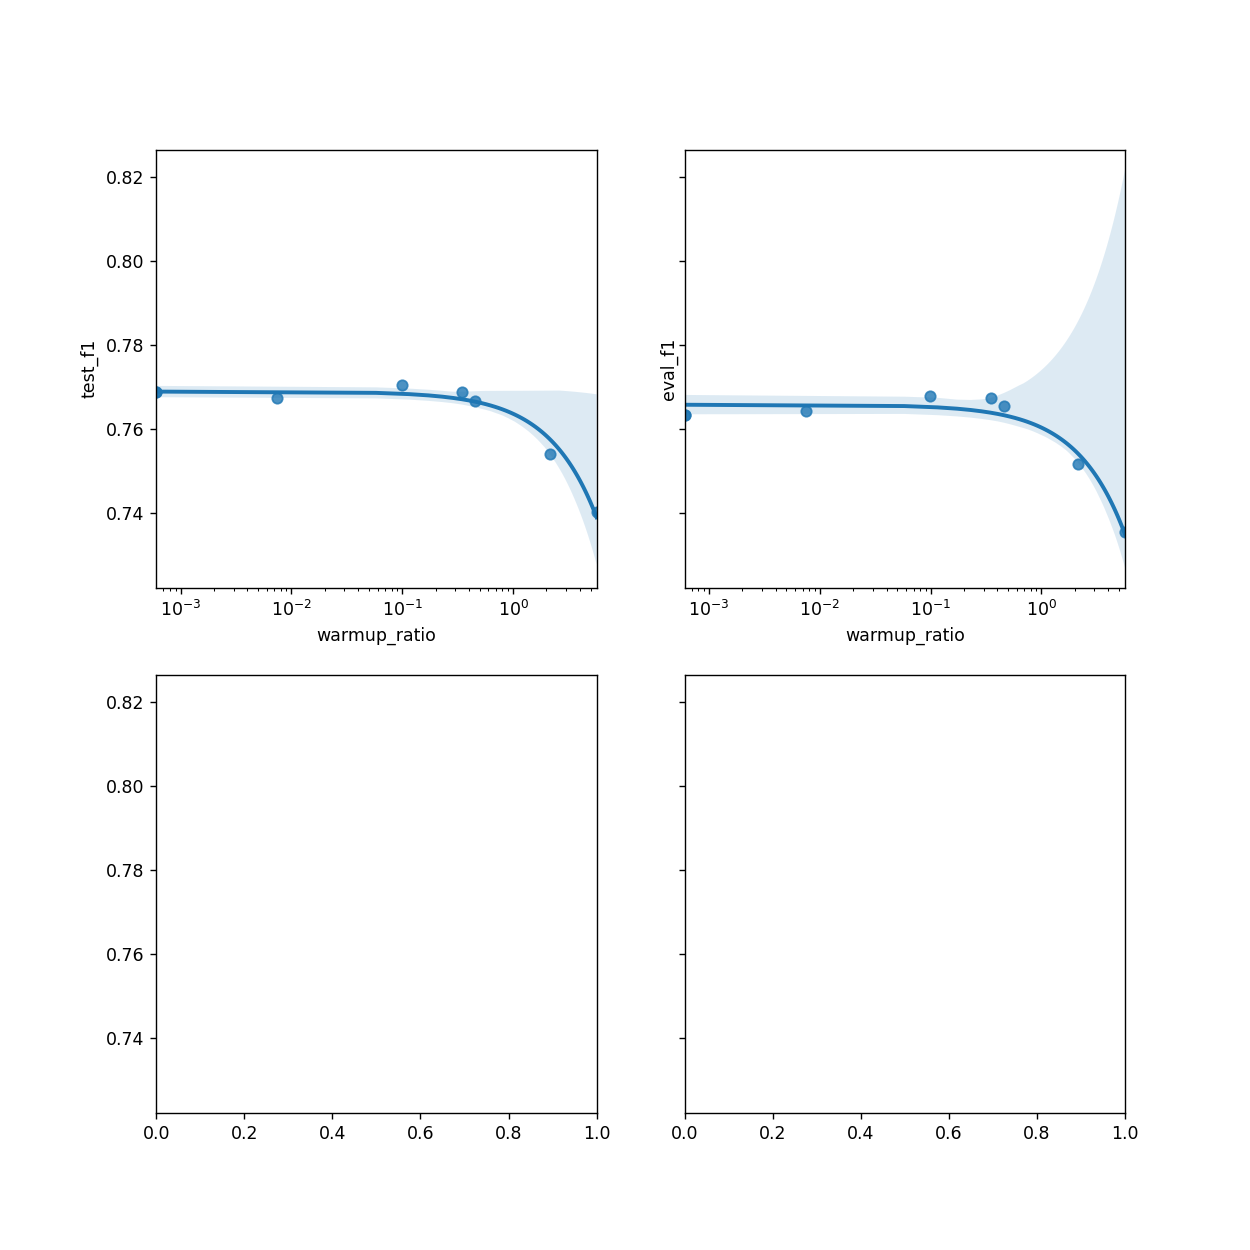

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#save_path = './hyperparameter_tuning/FIFO_wd'

fig, ax = plt.subplots(2,2, figsize=(10,10),sharey=True)
results_df = pd.DataFrame(results.values(), index=results.keys())
#results_dfresults_df.drop('00006').drop('00008')

sns.regplot(data=results_df, x='warmup_ratio', y='test_f1',ax=ax[0][0])
sns.regplot(data=results_df, x='warmup_ratio', y='eval_f1',ax=ax[0][1])
ax[0][0].set(xscale="log")
ax[0][1].set(xscale="log")

#sns.boxplot(data=results_df, ax=ax[1][0], x='per_device_train_batch_size',y='test_f1')
#sns.boxplot(data=results_df, ax=ax[1][1], x='per_device_train_batch_size',y='eval_f1')

#results_df.to_csv(save_path + '.csv')
#plt.savefig(save_path + '.png')

## Test

In [17]:
results_df[['test_f1','eval_f1','learning_rate','num_train_epochs','per_device_eval_batch_size',
       'per_device_train_batch_size', 'seed', 'weight_decay','warmup_ratio']].sort_values('test_f1')

,test_f1,eval_f1,learning_rate,num_train_epochs,per_device_eval_batch_size,per_device_train_batch_size,seed,weight_decay,warmup_ratio
00002,0.766888,0.766998,0.00002,2,32,32,42,0.015703,0.1
00009,0.766980,0.767683,0.00002,2,32,32,42,0.013311,0.1
00008,0.768067,0.768527,0.00002,2,32,32,42,0.006358,0.1
00003,0.768262,0.768613,0.00002,2,32,32,42,0.006251,0.1
00000,0.768477,0.768427,0.00002,2,32,32,42,0.001329,0.1
00004,0.768477,0.768427,0.00002,2,32,32,42,0.000294,0.1
00005,0.768477,0.768427,0.00002,2,32,32,42,0.000294,0.1
00006,0.768477,0.768427,0.00002,2,32,32,42,0.000149,0.1
00001,0.769169,0.766806,0.00002,2,32,32,42,0.071145,0.1
00007,0.769522,0.766260,0.00002,2,32,32,42,0.039676,0.1


In [15]:
classes = ['refutes','supports','not enough info']

claims = [
    'Barack Obama was part of the 109th United States Congress.',
    'France is a member of the European Air Transport Command.',
    'The Moon\'s diocese is the Roman Catholic Diocese of Arizona.',
    'Toyota is a member of the Linux Foundation.'
]

sentences = [
    'OBAMA, Barack, a Senator from Illinois and 44th President of the United States;',
    'The driving parties were France and Germany, who looked back at a strong bilateral cooperation in the field of air transport.',
    'It might sound strange, but in addition to encompassing nine counties and hundreds of cities, the Diocese of Orlando, Florida also has jurisdiction over an otherworldly object: the Moon.',
    'Carmakers are using new technologies to deliver on consumer expectations for the same connectivity in their cars as they’ve come to expect in their homes and offices.'
]

def get_predictions(claims, sentences, soft=False):
    enc = tokenizer(claims,sentences,max_length=MAX_LEN,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_tensors='pt',).to(DEVICE)

    # evaluate model:
    model.eval()

    with torch.no_grad():
        out = model(input_ids=enc['input_ids'], attention_mask=enc['attention_mask'])
        predicted_classes = [classes[i] for i in np.argmax(torch.softmax(out.logits,dim=1).tolist(), axis=1)]
        return predicted_classes, torch.softmax(out.logits,dim=1).tolist() if soft else out.logits

print(get_predictions(claims, sentences))

(['refutes', 'not enough info', 'refutes', 'not enough info'], tensor([[ 2.8462, -2.0639, -0.6641],
        [-2.2299, -1.3015,  3.4235],
        [ 3.8905, -2.8406, -1.1954],
        [ 1.0470, -4.3046,  2.4748]], device='cuda:0'))
